# Geometric Brownian Motion

Import libraries and define main functions

References:

* [How to apply Monte Carlo simulation to forecast Stock prices using Python](https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/)

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from mpl_toolkits.mplot3d import Axes3D
import random

np.random.seed(42)

def generate_gbm_price(mu, sigma, n, n_mc, dt = 1, x0 = 1):
    """ 
    Generate n_mc paths of n steps of a Geometric Brownian Motion:
    Reference: https://en.wikipedia.org/wiki/Geometric_Brownian_motion

    Parameters:
        mu: drift
        sigma: volatility
        n: number of steps
        n_mc: number of paths
        dt: time step
        x0: initial value
    Returns:
        x: array of shape (n_mc, n) containing the paths
    """        
    x = np.exp(
        (mu - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(n_mc, n)).T)
        
    x = np.vstack([np.ones(n_mc), x])
    x = x0 * x.cumprod(axis=0)
    return x[-1]

def gbm_stats(price: np.ndarray) -> None:
    """ Print modeling statistics of Geometric Browninan Motion Prices """
    mean_ = np.mean(price)
    median_ = np.median(price)
    print('Simulation: mean = %0.2f, median = %0.2f, mean/median = %0.2f' % (mean_, median_, mean_/median_))

def gbm_theory_expt1(mu: float, sigma: float, T: float) -> None:
    """ Print theoretical statistics of Geometric Browninan Motion Prices """
    mean_theory = np.exp(mu*T)
    median_theory = np.exp(mu*T - 0.5*sigma**2 * T)
    mode_theory = np.exp(mu*T - 1.5*sigma*T - 0.5*sigma**2 * T**2)
    print('Theory: mean = %0.2f, median = %0.2f, mean/median = %0.2f' % (mean_theory, median_theory, mean_theory/median_theory))

def gbm_theory_expt2(mu: float, sigma: float, T: float) -> None:
    """ Print theoretical statistics of Geometric Browninan Motion Prices """
    mean_theory = np.exp(mu*T + 0.5*sigma**2 * T**2)
    median_theory = np.exp(mu*T - 0.5*sigma**2 * T)
    print('Theory %0.2f %0.2f %0.2f' % (mean_theory, median_theory, mean_theory/median_theory))

def gbm_histogram(price: np.ndarray, bins: int = 100) -> None:
    """ 
    Plot histogram of Geometric Browninan Motion Prices

    Parameters:
        price: array of shape (n_mc, n) containing the paths
    Returns:
        None
    """

    log_fit = st.lognorm.fit(price, floc=0)
    x = np.linspace(0.001, 50, 1000)
    f_logn = st.lognorm.pdf(x, log_fit[0], log_fit[1], log_fit[2])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.hist(price, bins=bins, color='blue', alpha=0.2)

    #plt.plot(x, f_logn*np.sum(price), 'r-', lw=3, alpha=0.6, label='lognorm pdf')

    ax.set_xlim([0,20])
    ax.set_xlabel('Price', fontsize=14)

    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Histogram of Geometric Brownian Motion', fontsize=14)

    ax.tick_params(direction='in', length=8, width=1, labelsize=14)
     
    plt.show()
    plt.savefig(f'data/gbm_histogram.png')

def mean_to_median_theory(sigma: float, sigmah: float, T: int = 15) -> float:
    """ Theoretical mean to median ratio if mu is normally distributed: N(muh, sigmah) """  
    return np.exp(0.5*sigma**2 * T + 0.5*sigmah**2 * T**2)

def mean_to_median_3Dplot() -> None:
    """ Mean to median ratio 3D plot """

    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(111, projection='3d')

    x = np.arange(0.10, 0.5, 0.01)   # sigma
    y = np.arange(0.01, 0.2, 0.01)   # sigmah

    X, Y = np.meshgrid(x, y)

    zs = np.array(mean_to_median_theory(np.ravel(X), np.ravel(Y)))

    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)
    ax.set_xlabel('$\sigma$')
    ax.set_ylabel('$\hat\sigma$')
    ax.set_zlabel('Mean/Median')
    plt.savefig(f'data/mean_to_median_3D.png')

def mean_to_median_compare(sigma_fix: float, sigmah_fix : float, T: int) -> None:
    """ Mean to median ratio for variations of sigma and sigmah """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    x = np.arange(0.10, 0.5, 0.01)   # sigma
    y = np.arange(0.01, 0.2, 0.01)   # sigmah

    plt.plot(mean_to_median_theory(sigma = x, sigmah = sigmah_fix, T = T))
    plt.plot(mean_to_median_theory(sigma = sigma_fix, sigmah = y, T = T))
    ax.set_xlabel('Volatility', fontsize = 14)
    ax.set_ylabel('Mean/Median', fontsize = 14)
    ax.set_title('Mean/Median', fontsize = 18)

    ax.tick_params(direction='in', length=8, width=1, labelsize=14)

    plt.grid()
    plt.legend(['Sigma (sigmah = 0.05)', 'Sigmah (sigma = 0.20)'], fontsize = 14)
    plt.savefig(f'data/mean_to_median_compare.png')

## Experiment 1

In the first experiment, we fix the drift $\mu$ and volatility $\sigma$ parameters for the Geometrical Brownian Motion ([GBM](https://en.wikipedia.org/wiki/Geometric_Brownian_motion#Simulating_sample_paths)) assuming the price follows the model:

$$S_t = S_0 exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t - \sigma W_t\right]$$

where $W_t$ is a Wiener process and $t$ is time. The Wiener process $W_t$ is modeled with a normal distribution having zero mean and variance $\sqrt{t}$.

The GBM random variable $S_t$ is log-normally distributed

$$ mean = S_0 exp(\mu t)$$

$$ median = S_0 exp\left(\mu t - \frac{\sigma^2}{2}t\right) $$

We carry out $n_{mc}$ Monte-Carlo simulation trials of the GBM, taking the last price after $n$ steps and plot the resulting histogram distribution. As can be seen, the resulting histogram is log-normal with mean and median corresponding well to the theoretical values given above

Simulation: mean = 4.51, median = 3.33, mean/median = 1.35
Theory: mean = 4.48, median = 3.32, mean/median = 1.35


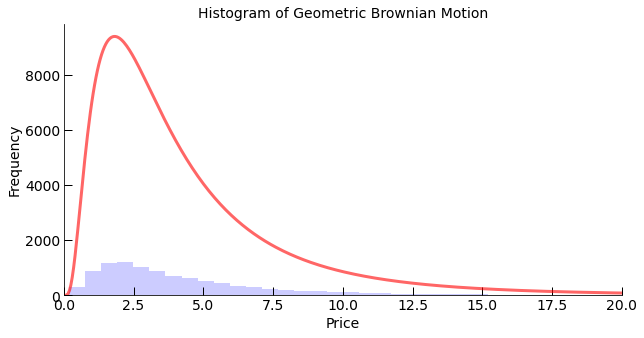

<Figure size 432x288 with 0 Axes>

In [113]:
mu = 0.1        # drift
sigma = 0.2     # volatility

n = 15          # number of intervals for T = 16 years
dt = 1          # step one year
x0 = 1          # start price
n_mc = 10000    # number of monte carlo iterations

x_last = generate_gbm_price(mu, sigma, n, n_mc, dt, x0)

last_price = np.ndarray.flatten(x_last)

gbm_stats(last_price)
gbm_theory_expt1(mu, sigma, n*dt)
gbm_histogram(last_price)

# Experiment 2

In the second experiment, we sample the GBM drift $\mu$ with the normal distribution $N(\mu_h, \sigma_h)$. For each trial we perform the GBM Monte-Carlo price simulation and record the final price into a list. Further, we plot the histogram and evaluate its mean, median and their ratio.

Simulation: mean = 5.86, median = 3.30, mean/median = 1.78
Theory 376.10 3.10 121.51


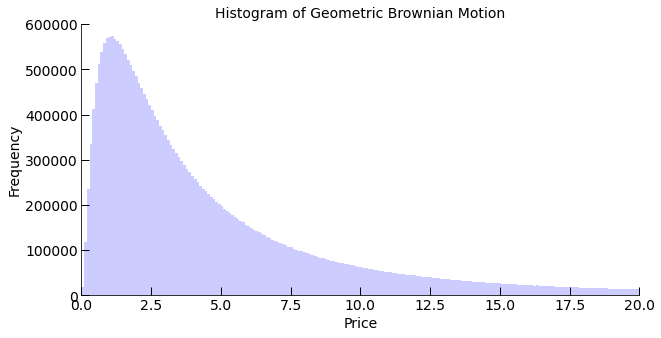

<Figure size 432x288 with 0 Axes>

In [83]:
def flatten_list(l):
    """ Flatten a list of lists """
    return np.array([item for sublist in l for item in sublist])

muh = 0.1       # geometric brownian motion drift
sigmah = 0.05   # geometric brownian motion volatility

n_mu = 3000     # number of samples for mu

# generate n_mu paths of n steps of a Geometric Brownian Motion
mu_list = np.random.normal(muh, sigmah, size=(n_mu, ))

x_last = []
for mu in mu_list:
    price = generate_gbm_price(mu, sigma, n, n_mc, dt, x0)
    x_last.append(price)

last_price = flatten_list(x_last)

gbm_stats(last_price)
gbm_theory_expt2(mu, sigma, n*dt)
gbm_histogram(last_price, bins=n_mc)

## Compare variations

1. Compute theoretical mean to medium ratio as a function of $\sigma$ and $\sigma_h$ parameters. The ratio grows fast with the increase of both parameters.

2. Two curves: a) fix $\sigma$ and vary $\sigma_h$ b) fix $\sigma_h$ and vary $\sigma$

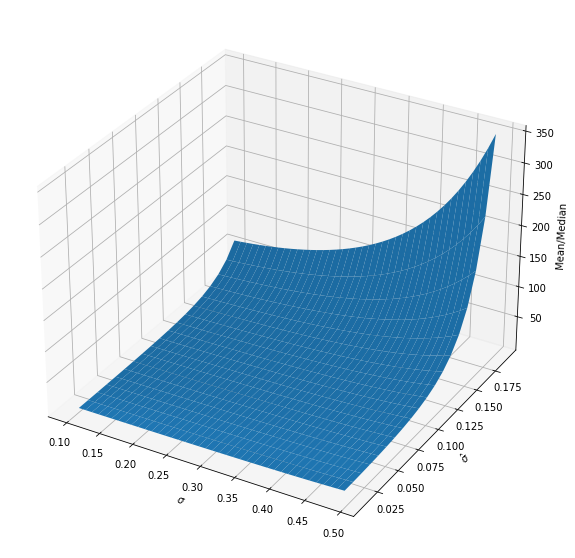

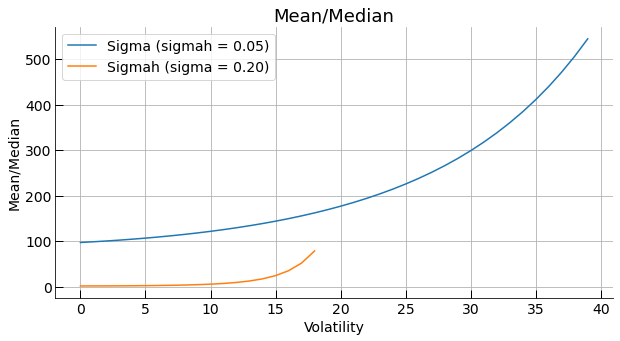

In [85]:
mean_to_median_3Dplot()

mean_to_median_compare(sigma_fix=0.20, sigmah_fix=0.20, T=n*dt)


## Experiment 3

In the third experiment, we sample the GBM volatility $\sigma$ distributed with a **normal distribution** $N(\mu_s, \sigma_s)$ (for simplicity). In reality $\sigma$ is distributed according to the [**Gamma distribution**](https://en.wikipedia.org/wiki/Gamma_distribution).

Simulation: mean = 4.18, median = 3.15, mean/median = 1.33
Theory 69439.47 2.19 31768.96


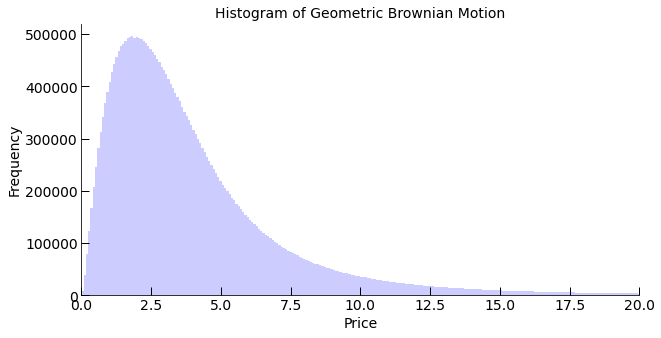

<Figure size 432x288 with 0 Axes>

In [86]:
mus = 0.2
sigmas = 0.05

sigma_list = np.maximum(0, np.random.normal(mus, sigmas, size=(n_mu, )))

x_last = []
for sigma in sigma_list:
    price = generate_gbm_price(mu, sigma, n, n_mc, dt, x0)
    x_last.append(price)

last_price = flatten_list(x_last)

gbm_stats(last_price)
gbm_theory_expt2(mu, sigma, n*dt)
gbm_histogram(last_price, bins=n_mc)